# Quick start
 
For example, we  use the spatial expression matrix of Bin1 of Stereo-Seq in the mouse olfactory bulb for the use of **stereopy** tools for downstream analysis.

The format of the original expression matrix of Bin1 is as follows: x, y are the spatial position of the gene in the tissue section, and count is the number of gene expression.

|  GeneID   | x | y | count |
|  ----  | ----  | ----| ----|
| Gene1  | 121 | 200 | 2 |
| Gene2  | 234 | 300 | 1 |
| ...  | ... | ... | ... |
| Gene n | 234 | 300 | 1 |



## Read the raw data of Stereo-Seq (bin1)

The resolution of Stereo-Seq sequencing technology is up to nanometer level. The nanopore radius of Bin1 is 250 nm. 

Generally, the **bin_size** parameter is set to combine the nanopores within a certain range into a bin unit for analysis. tthe side length of the bin unit is approximately 14 microns when **bin_size** is set to 20.

After merging according to a certain **bin_size**, we will uniformly generate the data into the format of AnnData for downstream analysis. For details of AnnData, see
*https://scanpy.readthedocs.io/en/latest/usage-principles.html#anndata*

In addition, stereopy can support reading 10x data, as detailed in the API documentation.

In [1]:
import warnings

warnings.filterwarnings('ignore')
import stereo as st


/data/workspace/install/Anaconda3/envs/st/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/workspace/install/Anaconda3/envs/st/lib/python3.9/site-packages/libpysal/examples/remotes.py:26: UserWarning: Remote data sets not available. Check connection.
  warnings.warn("Remote data sets not available. Check connection.")


In [2]:
mouse_data_path = '/data/workspace/st/data/stereopy_test/mouse/DP8400013846TR_F5.gem'
andata = st.io.read_stereo_data(mouse_data_path, bin_size=100)
print(andata)

2021-05-27 11:10:21 Spateo INFO: the martrix has 3347 bins, and 28553 genes.
2021-05-27 11:10:26 Spateo INFO: the size of matrix is 4.470348358154297e-08 G.


AnnData object with n_obs × n_vars = 3347 × 28553
    obsm: 'spatial'


## Preprocessing

Data preprocessing includes three modules: **Quality control**, **Filtering** and **Normalization**.

### Quality control

The quality control module mainly calculates the data quality distribution of the original data, and mainly counts three indicators:
- the number of genes expressed in the count matrix. (n_genes_by_counts)
- the total counts per cell. (total_counts)
- the percentage of counts in mitochondrial genes. (pct_counts_mt)

In [3]:
andata = st.preprocess.cal_qc(andata=andata)

Show the violin figure of the qc distribution.

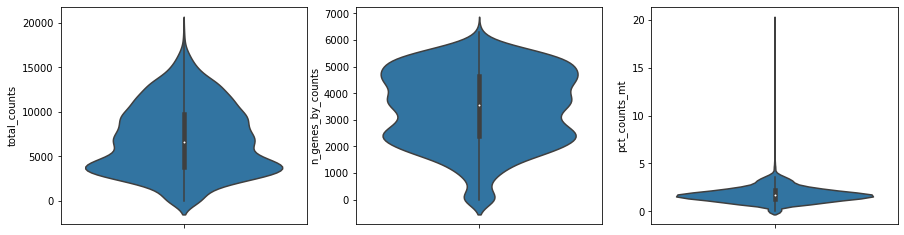

In [4]:
st.plt.plot_violin_distribution(andata)

Show the spatial scatter figure of the qc distribution.

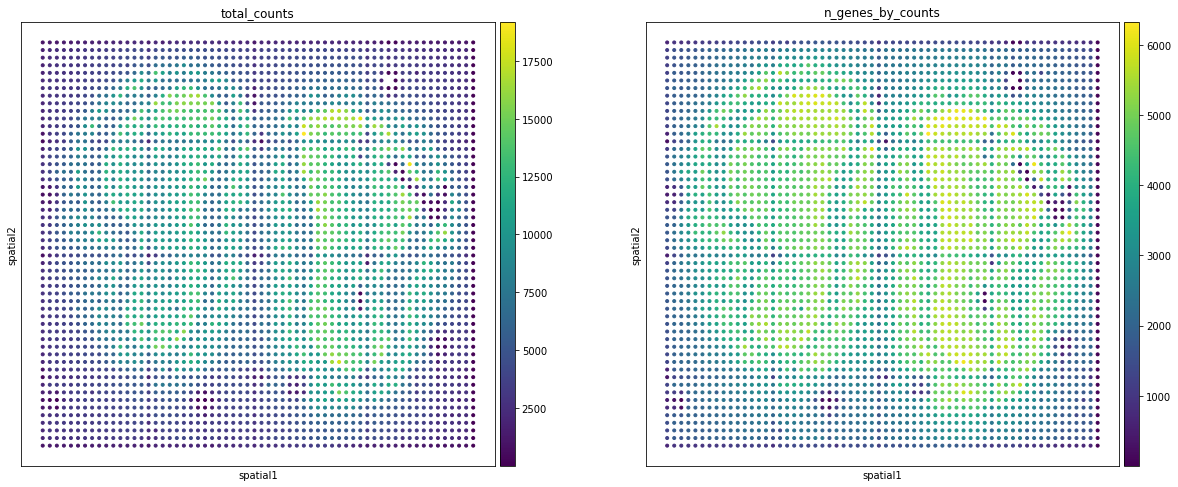

In [5]:
st.plt.plot_spatial_distribution(andata)

### Filtering

Generally, we will filter the `bin unit` based on the three quality control indicators total_count, n_genes_by_counts and pct_counts_MT.

In [6]:
st.preprocess.filter_cells(adata=andata, min_gene=200, n_genes_by_counts=3, pct_counts_mt=5, inplace=True)

In addition, we also provide `st.preprocess.filter_genes` function to filter genes and `st.preprocess.filter_coordinates` function to filer bin unit by its coordinate.

For detailed instructions, please refer to its api document.

### Normalization

In this module, we mainly provide three common standardization methods.

- normalize_total
- quantile
- zscore

In [7]:
normalizer = st.preprocess.Normalizer(data=andata, method='normalize_total', inplace=True, target_sum=10000)
normalizer.fit()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.9984013 , 0.        , ..., 0.99920064, 0.        ,
        0.        ],
       ...,
       [0.        , 0.86737794, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.0563009 , 0.        ,
        0.        ]], dtype=float32)

## Dimensionality reduction

By default, PCA is used to reduce dimensionality. 

In addition, it supports `tsen`, `umap`, `factor analysis`, `low variance` and other dimensionality reduction methods.See the API related documentation for details.

In [8]:
dim_reduce = st.tools.DimReduce(andata=andata, method='pca', n_pcs=30, min_variance=0.01, n_iter=250, n_neighbors=10, min_dist=0.3, inplace=False, name='dim_reduce')
dim_reduce.fit()

In [55]:
import pickle

pickle.dump(andata, open('./output/quick_start.pk', 'wb'))

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import stereo as st


andata = pickle.load(open('./output/quick_start.pk', 'rb'))

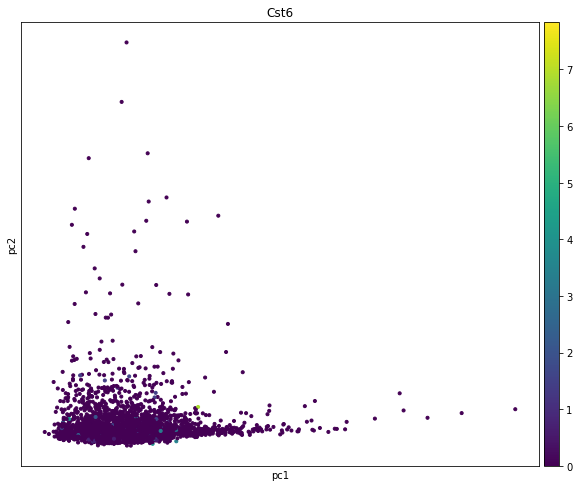

In [6]:
st.plt.plot_dim_reduce(andata, plot_key=['Cst6'])

## Clustering

Currently we provide two common clustering methods, including leiden and louvain. 

In this tool, you can re-run the normalization method before clustering if the `normalize_method` parameter is not None. Then by default, we use pca to reduce the dimensionality of the new normalization method, and then using the top 30 pcs to run clustering.

In [7]:
cluster = st.tools.Clustering(data=andata, method='leiden', dim_reduce_key='dim_reduce', n_neighbors=30, name='clustering')
cluster.fit()

Show the spatial distribution of the clusering result.

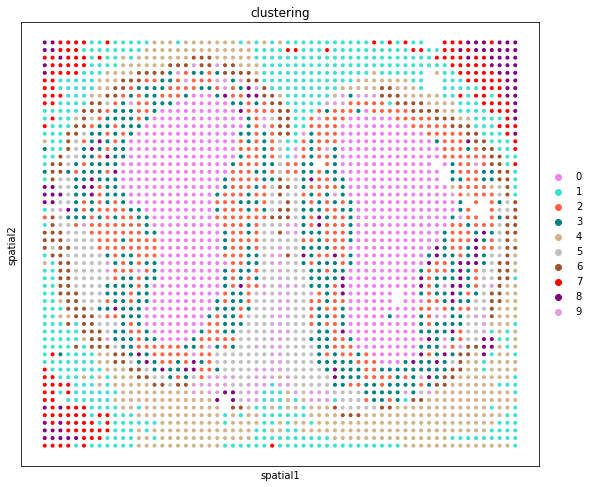

In [10]:
st.plots.plot_spatial_cluster(adata=andata, cluster_names=['clustering'], pos_key='spatial')

It can also show the dimensionality reduction spatial distribution of the clustering result if the `pos_key` is set to be dimensionality reduction tool's name.

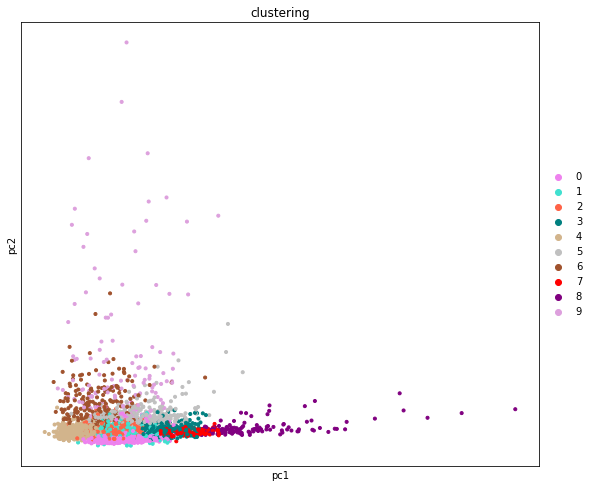

In [11]:
st.plots.plot_spatial_cluster(adata=andata, cluster_names=['clustering'], pos_key='dim_reduce')

## Find marker genes

By default, the `.X` attribute of AnnData is used to compute the result. We support two tools to find marker genes, including `st.tools.FindMarker` and `st.tools.SpatialLag`.

### Hypothesis test
In `st.tools.FindMarker`, it provides a hypothesis test to analyze differences between two groups. It support two methods including `t-test` and `wicoxon`.

In [26]:
marker = st.tools.FindMarker(data=andata, cluster='clustering', corr_method='bonferroni', method='t-test', name='marker_test')
marker.fit()

Find marker gene: 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]
2021-05-28 11:10:57 Spateo WARNING: your AnnData.uns['marker_test'] is used by others, replacing it with a StereoResult.


Then, show the score of top 10 marker genes for the each group.

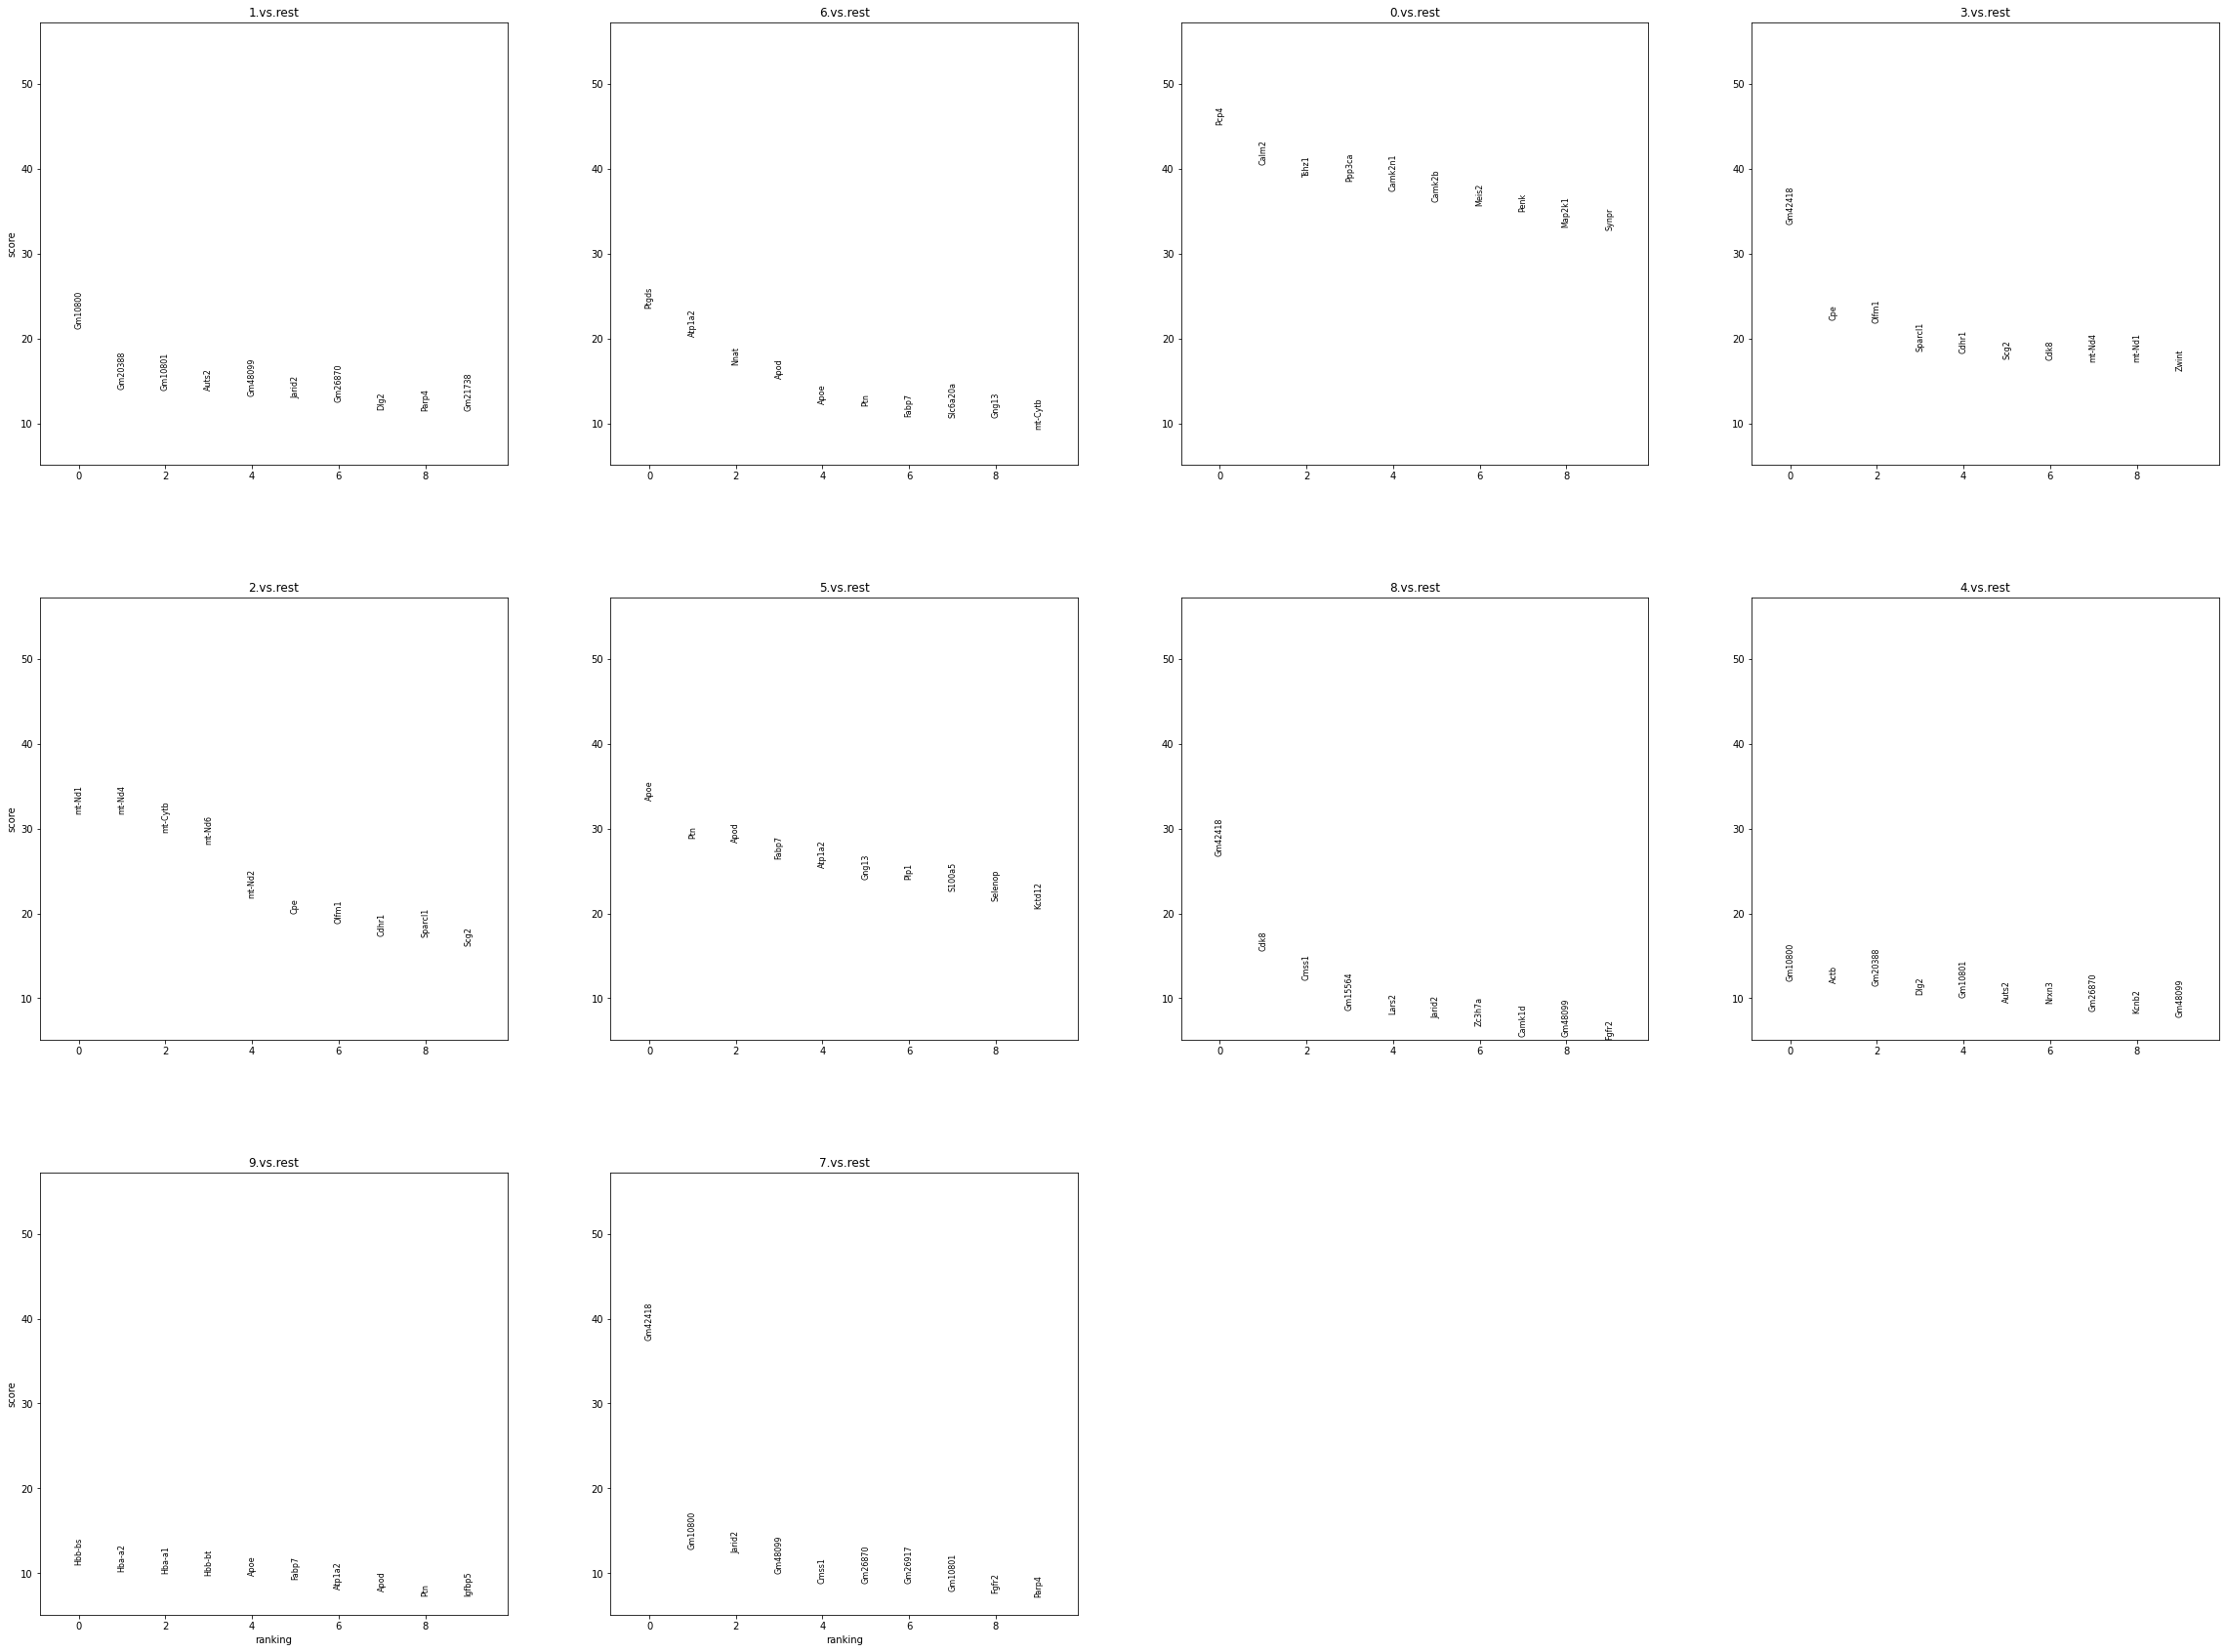

In [30]:
st.plt.plot_marker_genes(adata=andata, n_genes=10, find_maker_name='marker_test')

In [29]:
andata.uns['marker_test']['1.vs.rest'].top_k_marker(top_k_genes=10, ascend=False, sort_key='scores')

,genes,scores,pvalues,pvalues_adj,log2fc
9760,Gm10800,21.101646,2.100798e-74,5.998408e-70,13.625463
26395,Gm20388,13.959654,2.427094e-38,6.930082e-34,17.820795
23235,Gm10801,13.882109,6.907171e-38,1.972204e-33,4.967365
19542,Auts2,13.856010,1.526443e-37,4.358452e-33,17.481253
13176,Gm48099,13.152459,8.335549e-35,2.380049e-30,7.280899
11121,Jarid2,12.927252,8.365243e-34,2.388528e-29,12.399784
25125,Gm26870,12.505767,8.863599e-32,2.530823e-27,3.556817
13377,Dlg2,11.638679,4.886943e-28,1.395369e-23,15.900744
23668,Parp4,11.477016,1.525292e-27,4.355165e-23,3.282708
20491,Gm21738,11.456015,2.169239e-27,6.193828e-23,2.914225


Show the heatmap plot of top 10 marker genes.

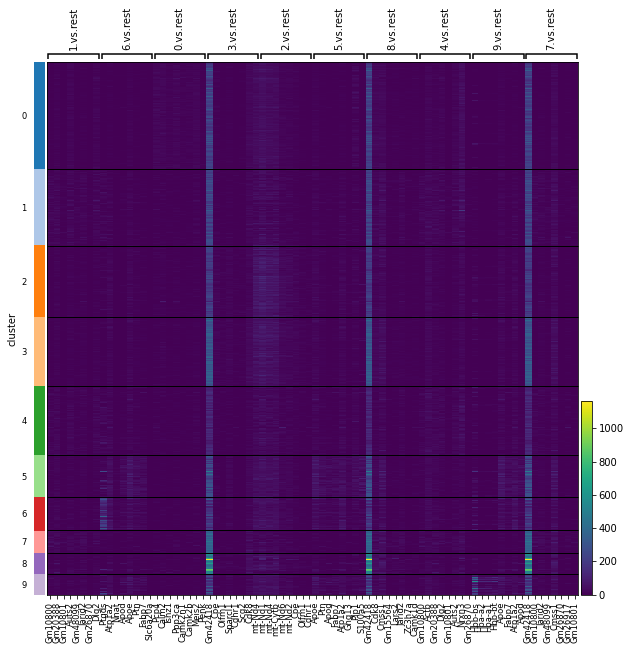

In [32]:
st.plt.plot_heatmap_marker_genes(adata=andata, cluster_name='clustering', fine_maker_name='marker_test', num_show_gene=8)

### spatial lag model

By default, the tool calculate all genes's lag coefficient, which takes some time. 

If you only want to see the genes you are interested in, you can set the genes through the parameter `gene` .

In [33]:
lag = st.tools.SpatialLag(data=andata, cluster='clustering')
lag.fit()

performing GM_lag_model and assign coefficient and p-val to cell type: 28553it [31:55, 14.91it/s]


SpatialLagResult of spatial_lag. 
  params: {'data': AnnData object with n_obs × n_vars = 3273 × 28553
    obs: 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'clustering'
    uns: 'dim_reduce', 'clustering', 'marker_test', 'spatial_lag'
    obsm: 'spatial', 'method': 'gm_lag', 'name': 'spatial_lag', 'cluster': 'clustering', 'genes': None, 'random_drop': True, 'drop_dummy': None, 'n_neighbors': 8}
    result: a DataFrame which has `genes`,`lag_coeff`, `lag_zstat`, `lag_pval` columns.
    the shape is: (28553, 36)

Show the result of spatial lag model.

In [48]:
andata.uns['spatial_lag'].score

,const_lag_coeff,const_lag_zstat,const_lag_pval,1_lag_coeff,1_lag_zstat,1_lag_pval,6_lag_coeff,6_lag_zstat,6_lag_pval,0_lag_coeff,...,4_lag_pval,9_lag_coeff,9_lag_zstat,9_lag_pval,7_lag_coeff,7_lag_zstat,7_lag_pval,W_log_exp_lag_coeff,W_log_exp_lag_zstat,W_log_exp_lag_pval
Iyd,0.0,13.46056,0.0,0.0,0.056549,0.954905,-0.0,-3.907563,0.000093,-0.0,...,0.000542,-0.0,-11.054426,0.0,-0.0,-11.960677,0.0,1.0,126180040290664272.0,0.0
Rarb,0.0,16.521538,0.0,-0.0,-11.816965,0.0,-0.0,-3.050368,0.002286,-0.0,...,0.107645,-0.0,-4.021895,0.000058,-0.0,-3.242075,0.001187,1.0,6399440673649731.0,0.0
Irx2,-0.0,-2.27271,0.023044,0.0,7.487105,0.0,-0.0,-5.804079,0.0,-0.0,...,0.682396,0.0,0.930905,0.351903,-0.0,-1.573045,0.115708,1.0,114601771562122768.0,0.0
3300002A11Rik,0.0,18.742546,0.0,-0.0,-12.819551,0.0,-0.0,-16.572084,0.0,-0.0,...,0.0,-0.0,-9.882764,0.0,-0.0,-8.218894,0.0,1.0,106285634107647536.0,0.0
Gm12946,0.0,2.276698,0.022804,0.0,7.942856,0.0,-0.0,-8.335728,0.0,-0.0,...,0.002284,-0.0,-16.062968,0.0,-0.0,-13.694554,0.0,1.0,201367820094472832.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cst6,0.0,10.516882,0.0,0.0,0.243903,0.807306,0.0,0.393624,0.693858,-0.0,...,0.000001,-0.0,-4.51893,0.000006,0.0,3.619165,0.000296,1.0,50826626299372016.0,0.0
Ascl3,0.0,9.524975,0.0,-0.0,-3.055332,0.002248,0.0,12.598778,0.0,-0.0,...,0.000289,-0.0,-5.230889,0.0,-0.0,-4.320097,0.000016,1.0,100451245031858672.0,0.0
Gmpr,0.0,9.391973,0.0,-0.0,-3.804836,0.000142,0.0,3.066049,0.002169,-0.0,...,0.0,-0.0,-1.37376,0.169516,0.0,14.603169,0.0,1.0,37505532397988568.0,0.0
Gm28863,0.0,5.008487,0.000001,0.0,10.167506,0.0,-0.0,-1.164742,0.244123,0.0,...,0.151654,0.0,2.059288,0.039467,-0.0,-3.238117,0.001203,1.0,78119007377666144.0,0.0


['1', '6', '0', '3', '2', '5', '8', '4', '9', '7']


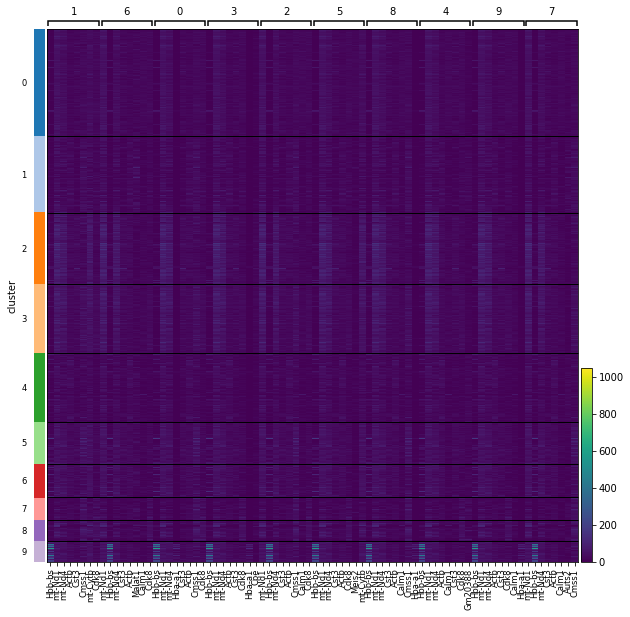

In [2]:
st.plt.plot_heatmap_marker_genes(adata=andata, cluster_name='clustering', fine_maker_name='spatial_lag', num_show_gene=8)

## spatial pattern score

In [3]:
sps = st.tools.SpatialPatternScore(data=andata)
sps.fit()